# Interpretable Machine Learning: PD6

In [1]:
import inspect
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import zipfile

from numpy.random import choice
from sklearn.utils.estimator_checks import is_classifier, is_regressor
from statsmodels.nonparametric.smoothers_lowess import lowess
from xgboost import XGBClassifier

Przekopiowałem kod do wczytywania i transformacji danych oraz trenowania modelu z PD1.

In [2]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'

def download_extract_zip(url):
    zipped = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(zipped.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile
                
data = download_extract_zip(url)
data = pd.read_stata(next(data)[1])

In [3]:
variables = ['ppage', 'w6_q24_length', 'w6_sex_frequency', 'w6_q23', 'w6_q27']
# Selecting variables
X = data[variables]
# Filtering observations
logical_filter = (~data.w6_q23.isna()) & (data.w6_q23 != 'Refused') & (data.w6_q27 != 'Refused')
X = X[logical_filter]
# Casting types and imputation
X.ppage = X.ppage.astype(float)
X.w6_q24_length = X.w6_q24_length.astype(float)
X.w6_sex_frequency = X.w6_sex_frequency.cat.codes.replace({-1:5, 0:5})
X.w6_q23 = X.w6_q23.astype(str)
X.w6_q27 = X.w6_q27.astype(str)
# One Hot Encoding
X = pd.get_dummies(X)
X.columns = map(lambda x: x.replace('[Partner Name]', 'PARTNER'), X.columns)

y = 1 - data.S1.cat.codes
y = y[logical_filter]

In [4]:
xgb = XGBClassifier(seed=123)
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

Na początek wyznaczyłem potrzebne później wartości, czyli predykcje z modelu oraz reszty.

In [5]:
y_hat = xgb.predict_proba(X)[:,1]
resid = y - y_hat

## LOESS z przedziałami ufności

Standardowe implementacje LOESS w Pythonie wydają się nie mieć prosto zaimplementowanego rysowania przedziałów ufności. Dlatego napisałem odpowiednią klasę samemu - użyłem bootstrapa (domyślnie 1000 iteracji). Niestety LOESS ze `statsmodels` nie ma metody `predict`, więc pomiędzy punktami stosuję interpolację liniową, co oczywiście da pewien błąd.

In [38]:
class BootstrapLOWESS:
    def __init__(self, x, y, n_points = 1000, n_iter=1000):
        string = inspect.getouterframes(inspect.currentframe())[1]
        string = re.search(r'BootstrapLOWESS\((.*)\)\\', str(string))[1]
        self.x = np.array(x)
        self.xlab = re.search(r'(.+?)(?:,|$)', string)[1]
        self.y = np.array(y)
        self.n_points = n_points
        self.n_iter = n_iter
        self.lowess = lowess(y, x)
        
    def create_samples(self):
        self.samples = []
        n = len(self.x)
        min_x, max_x = min(self.x), max(self.x)
        which = choice(np.arange(n), size=n*self.n_iter)
        for i in range(self.n_iter):
            which_curr = which[(n*i):(n*i + n)]
            lowess_curr = lowess(endog=self.y[which_curr],
                                 exog=self.x[which_curr])
            x = np.linspace(min_x, max_x, num=self.n_points)
            y = np.interp(x=x, xp=lowess_curr[:,0], fp = lowess_curr[:,1])
            self.samples.append(
                np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)
            )
        
    def plot_all(self):
        plt.scatter(self.x, self.y, alpha=0.05)
        for i in range(self.n_iter):
            plt.plot(
                self.samples[i][:,0],
                self.samples[i][:,1],
            )
        plt.xlabel(self.xlab)
        plt.ylabel('Residuals')
        
    def plot_ci(self, ci=0.95):
        def q_min(series):
            return series.quantile(q=(1-ci)/2)
        def q_max(series):
            return series.quantile(q=1 - (1-ci)/2)
        df = pd.concat(map(pd.DataFrame, self.samples), ignore_index=True)
        grouped = df.rename(index=str, columns={0:'x', 1:'y'})\
                    .groupby('x')\
                    .agg({'y':[q_min, q_max]})\
                    .reset_index()
        grouped.columns = list(map(lambda x: x[0] + x[1], 
                                   grouped.columns.to_flat_index().tolist()))
        # Scatterplot of points
        plt.scatter(self.x, self.y, alpha=0.05)
        plt.xlabel(self.xlab)
        plt.ylabel('Residuals')
        # LOWESS on all points
        plt.plot(self.lowess[:,0], self.lowess[:,1], color='red')
        plt.fill_between(x=grouped.x,
                         y1=grouped.yq_min,
                         y2=grouped.yq_max,
                         color='grey',
                         alpha=0.5)
        
        plt.show()

## Reszty vs predykcje

W oczywisty sposób reszty w modelu klasyfikacyjnym będą mniej lub bardziej rozdzielone na osobne grupy. Dla wykresu reszty vs `y_hat` w przypadku dobrego dopasowania modelu powinniśmy zobaczyć krzywą LOESS mniej więcej płaską, na poziomie 0. W OLS `y_hat` jest rzutem `y` na przestrzeń rozpiętą przez predyktory, więc w przypadku dobrej specyfikacji chcielibyśmy zobaczyć niezależność reszt i `y_hat`.

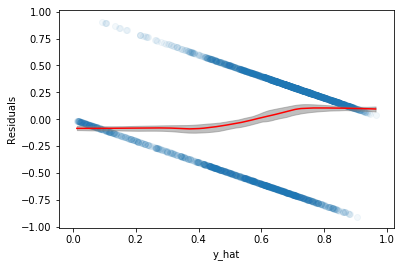

In [39]:
res_pred_lowess = BootstrapLOWESS(y_hat, resid, 1000, 100)
res_pred_lowess.create_samples()
res_pred_lowess.plot_ci()

Widać, że krzywa jest nieznacznie rosnąca.

## Reszty vs `ppage`

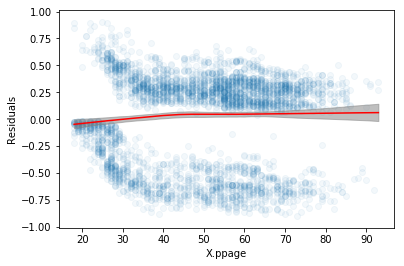

In [40]:
ppage_lowess = BootstrapLOWESS(X.ppage, resid, 1000, 100)
ppage_lowess.create_samples()
ppage_lowess.plot_ci()

## Reszty vs `w6_q24_length`

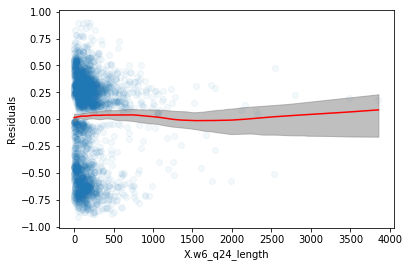

In [41]:
w6_q24_length_lowess = BootstrapLOWESS(X.w6_q24_length, resid, 1000, 100)
w6_q24_length_lowess.create_samples()
w6_q24_length_lowess.plot_ci()

W przypadku wykresów reszty vs predyktory, dopasowane krzywe LOESS pozostają relatywnie płaskie i nie odbijają od 0, co sugeruje, że reszty są niezależne od ciągłych zmiennych objaśniających.

## Odległości Cooka

In [116]:
def cook_distances(model, X, y):
    assert is_classifier(model) or is_regressor(model)
    # Define required quantities
    n = X.shape[0]
    p = X.shape[1]
    y_hat = model.predict_proba(X)[:,1]
    rss = np.sum((y - y_hat) ** 2)
    
    def single_distance(index):
        model.fit(X.drop(index, axis=0), y.drop(index))
        return model.predict_proba(X)[:,1].tolist()
    y_hat_submodel_matrix = np.array(pd.Series(X.index).apply(single_distance).tolist())
    cds = ((y_hat_submodel_matrix - y_hat) ** 2).sum(axis=1) / p / rss
    return cds

In [117]:
cd = cook_distances(xgb, X, y)

In [124]:
X.assign(
    cd = cd,
    y = y
).sort_values(
    by=['cd'], 
    ascending=False
).head(20)

,ppage,w6_q24_length,w6_sex_frequency,w6_q23_I earned more,w6_q23_We earned about the same amount,w6_q23_PARTNER earned more,w6_q23_PARTNER was not working for pay,w6_q27_No,w6_q27_Yes,cd,y
741,64.0,41.0,4,1,0,0,0,0,1,0.000404,0
667,70.0,382.0,5,0,0,1,0,1,0,0.000305,0
3428,68.0,117.0,4,1,0,0,0,1,0,0.000304,0
328,66.0,114.0,4,1,0,0,0,1,0,0.000304,0
1667,75.0,221.0,5,1,0,0,0,1,0,0.000304,0
1136,62.0,250.0,5,0,0,1,0,1,0,0.000292,1
2588,55.0,149.0,3,1,0,0,0,1,0,0.000286,0
1875,60.0,351.0,5,0,0,1,0,1,0,0.000284,1
2977,60.0,430.0,5,0,0,1,0,1,0,0.000284,1
1151,63.0,390.0,5,0,0,1,0,1,0,0.000284,1
